# Lab 6: Bayesian Logistic Regression

## Introduction

This lab has been modified into a tutorial activity.

In this tutorial, you can explore the regularizing impact of different features of a prior in a Bayesian logistic regression problem. You will learn how to:
1. Understand a logistic likelihood model
2. Select non-conjugate priors for their regularizing effects
3. Compare the biasing effects of different priors based on their tail-behavior

The data in this lab is drawn from:
- Racine et al. *Bayesian Methods in Practice: Experiences in the Pharmaceutical Industry.* Journal of the Royal Statistical Society. 1986. [JSTOR link](https://www.jstor.org/stable/2347264) (this is the source for the toxicity data set used in BDA Chapter 3.7 and in Chapter 5)

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6302778) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

In [2]:
# load whatever packages you prefer here. We've added a reference list here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, beta

## Data

In [5]:
# Load toxicity data
file_path = "toxicology_data.csv"
toxicity_data = pd.read_csv(file_path)

## Bayesian Logistic Regression Models

In this lab, you will explore the regularizing effects of different prior models on two generalized linear models (likelihood models that compose a linear combination of features with a nonlinear link). Here we focus on a logistic regression model for the toxicity of a compound.

### Likelihoods:
#### Toxicity Study

The following example is based on the first logistic regression example in BDA (see Chapter 3.7, page 74). The data is excerpted from Racine et al.'s review article on applications of Bayesian statistics in the pharmaceutical industry. 

The article introduces a Bayesian regression model for the toxicity of a substance based on an animal trial. While establishing the toxicity of chemical substances is important in pharmaceutical research, animal trials that harm their subjects should only be performed when necessary and no reasonable alternatives exist. Ethical and legal requirements demand that any such studies should be performed on as few animals as possible while retaining enough statistical power to establish the conclusions needed for safe drug development. Since these studies were, as of Racine's writing, performed routinely, past information, or information from studies on similar substances, could be used to inform priors. The need for robust analyses from small sample sizes motivates the use Bayesian analysis in these examples. For further reasons to adopt a Bayesian approach, see [Racine et al](https://www.jstor.org/stable/2347264).

The data consists of four trials for the acute toxicity of a substance, each involving five subject animals. Note the small number of subjects used in the reported trial (20 in total, 5 per treatment group). The dose $\{x_i\}_{i=1}^4$ varied between the four groups, increasing from 422 mg/ml to 2069 mg/ml. In each, the number of animals killed by the substance, $\{y_i\}_{i=1}^4$, was recorded. 

Following BDA, consider the logistic regression model:

$$
\begin{aligned}
& \textbf{Linear Comb. of Features: } \quad \eta(x,\beta) = \beta_0 + \beta_1 \log(x) & \\
& \textbf{Logistic Link: } \hspace{1.2 in} q(x,\beta) = \text{logistic}(\eta(x,\beta)) = [1 + \exp(-\eta(x,\beta))]^{-1} & \\
& \textbf{Binomial Sampling Dist: } \hspace{0.3 in} Y|x,\beta \sim \text{Bin}(n,q(x,\beta)). 
\end{aligned}
$$

Then, given the data $\{(x_i,y_i)\}_{i=1}^4$, the likelihood of the regression parameters $\beta$ is:

$$
\text{Lik}(\beta) \propto \prod_{i=1}^4 q(x_i,\beta)^{y_i} (1 - q(x_i,\beta))^{n - y_i} = \prod_{i=1}^4 (1 + e^{-\beta_0 - \beta_1 \log(x_i)})^{-y_i} (1 + e^{\beta_0 + \beta_1 \log(x_i)})^{-(n-y_i)}
$$

We want to infer the regression coefficients, $\beta = [\beta_0,\beta_1]$ from the data $\{(x_i,y_i)\}_{i=1}^4$. In particular, toxicity regulation is based on the dosage level $x$ for which the substance has a 50\% chance of causing harm (here defined as causing a fatal reaction). This is the level at which $\eta(x,\beta) = 0$, or, is $x_*(\beta) = \exp(-\beta_0/\beta_1)$. We will study how the posterior on $x_*$ changes under different prior specifications.


##### Toxicity: Define likelihood function for logistic regression

In [13]:
def log_likelihood_toxicity(beta, data):
    log_prob = 0
    for _, row in data.iterrows():
        x, y = row['Dose_(mg/ml)'], row['Number_Harmed']
        eta = beta[0] + beta[1]*np.log(x)
        
        log_prob += -y*np.log(1 + np.exp(-eta)) - (5 - y)*np.log(1 + np.exp(eta)) 
    return log_prob

### Priors:

#### Toxicity Study:

We will consider four possible choices of prior. They are listed below in order of generality. Each includes its predecessors as a special case.

1. An improper uniform prior on $\beta$ (see both BDA and Racine)
2. A  Gaussian prior on $\beta$ formed from consultation with toxicology experts (see Racine):
$$
\beta \sim \mathcal{N}(\bar{\beta},C_{\beta}) \text{ where } \bar{\beta} = [-17.31,2.57], \quad C_{\beta}(\sigma) = \left[\begin{array}{cc} 1053.72 & -156.45 \\ -156.45 & 23.24 \end{array}\right] + \sigma^2 I
$$
where $\sigma > 0$ is a free parameter introduced to weaken the prior. When $\sigma = 0$, this prior is singular (places all of the prior density on a line). 
3. A Gaussian prior on $\beta$ designed to introduce a stronger regularizing effect. In particular, use the covariance:
   $$R_{\beta}(\sigma,\mu) = (C_{\beta}^{-1} + \mu^{-2} I)^{-1} $$
Adding a multiple of the identity inside the inverse has the effect of soft-thresholding the largest eigenvalue of the covariance from above. The smaller $\mu$, the larger the regularizing effect.
4. A yet weaker prior formed by replacing a Gaussian density with a Student-t density
$$ 
\beta \sim p_{\beta} \text{ where } p_{\beta}(\beta) \propto \left(1 + \frac{1}{\nu} (\beta - \bar{\beta})^{\intercal} R_{\beta}^{-1} (\beta - \bar{\beta}) \right)^{-\frac{\nu + 2}{2}}
$$
where $\nu$ is a shape parameter. When $\nu = 1$ the prior is a multivariate Cauchy. When $\nu \rightarrow \infty$, the prior converges to the multivariate normal prior with mean $\bar{\beta}$ and covariance $R_{\beta}$.

Notice that the 4th prior family encompasses the previous three. As such, it is enough to implement (4), then pick the parameters appropriately. The first is recovered by setting $\mu$ arbitrarily close to zero. The second is recovered by setting $\mu$ and $\nu$ arbitrarily large. The third is recovered by setting $\nu$ arbitrarily large. In general, the prior parameters $\sigma, \mu, \nu$ may be interpreted as:

1. $\sigma$ weakens the expert provided prior by adding variance. When $\sigma = 0$ the expert provided prior assumes that $\beta_0$ and $\beta_1$ satisfy a strict linear relationship. Using (small) nonzero $\sigma$ allows some variation about this relationship.
2. $\mu$ tightens the prior by introducing a soft threshold on the prior variance. The smaller $\mu$, the smaller the allowed variance. This is an important regularization parameter since the expert provided prior allows a large degree of variation in the regression parameters along a direction in the parameter space that is not well constrained by the likelihood.
3. $\nu$ relaxes the tails of the prior so that the tails decay according to a power-law. This fat-tailed behavior allows more outliers when sampling from the prior, so does not as strongly suppress the tails of the posterior. This allows more robust inference since, the slower the prior tails decay, the less bias is introduced by the prior given data that suggests an outlier. The slower the tailes decay, the fewer samples are needed to move the posterior towards the likelihood when the likelihood suggests that the true parameters would have been surprising under the prior. This makes the posterior inference more reactive to the likelihood (it is more amenable to accepting outliers), so increases the variance in the posterior with respect to sampling while decreasing the biases introduced by regularization.

In [20]:
# Implement the uniform prior. Your code should return the log prior density up to an additive constant
def log_prior_uni_toxicity(beta):
    return 0

In [22]:
# Implement the normal prior. Your code should return the log prior density up to an additive constant
def log_prior_normal_toxicity(beta, sigma):
    beta_centered = beta - np.array([-17.31,2.57])
    C = np.array([[1053.72, -156.45], [-156.45, 23.24]]) + (sigma**2)*np.eye(2)
    log_prob = -0.5*beta_centered.T @ np.linalg.inv(C) @ beta_centered
    return log_prob

In [24]:
# Implement the regularized normal prior. Your code should return the log prior density up to an additive constant
def log_prior_reg_normal_toxicity(beta, sigma, mu):
    beta_centered = beta - np.array([-17.31,2.57])
    C = np.array([[1053.72, -156.45], [-156.45, 23.24]]) + (sigma**2)*np.eye(2)
    R = np.linalg.inv(np.linalg.inv(C) + mu**(-2)*np.eye(2))
    log_prob = -0.5*beta_centered.T @ np.linalg.inv(R) @ beta_centered
    return log_prob

In [26]:
# Implement the student-t prior. Your code should return the log prior density up to an additive constant
def log_prior_student_toxicity(beta, sigma, mu, nu):
    beta_centered = beta - np.array([-17.31,2.57])
    C = np.array([[1053.72, -156.45], [-156.45, 23.24]]) + (sigma**2)*np.eye(2)
    R = np.linalg.inv(np.linalg.inv(C) + mu**(-2)*np.eye(2))
    quadratic_term = beta_centered.T @ np.linalg.inv(R) @ beta_centered
    log_prob = -((nu + 2)/2)*np.log(1 + quadratic_term/nu) # the larger nu, the closer this is to Gaussian
    return log_prob

## Posterior Inference

### Sampling:

The code below implements a Markov chain Monte-Carlo sampler (MCMC) that can approximately sample from a posterior distribution by iteratively proposing new values for the unknowns, and accepting or rejecting the proposals based on the posterior odds. The specific algorithm is an instance of the Metropolis-Hastings method. We will discuss this in the next unit. For now, you may accept this as a black box tool that produces samples from the posterior.

In [40]:
def metropolis_hastings(beta, data, prior_param, iterations=200000, step_size=0.1, burn_in = 1000, stride = 100):
    # initialize chain
    samples = []
    
    current_ll = log_likelihood_toxicity(beta, data)

    sigma = prior_param[0]
    mu = prior_param[1]
    nu = prior_param[2]
    current_lpr = log_prior_student_toxicity(beta, sigma, mu, nu)
    
    current_lpo = current_ll + current_lpr

    k = 0 # counter for step of sampler

    # iterate the Markov chain
    for _ in range(iterations):
        # propose new sample location
        new_beta = beta + step_size*np.random.normal(0, [7,1], size=2) # default scales [7, 1] 

        # evaluate proposal
        new_ll = log_likelihood_toxicity(new_beta, data)
        
        new_lpr = log_prior_student_toxicity(new_beta, sigma, mu, nu)
        
        new_lpo = new_ll + new_lpr

        # decide whether to accept or reject the proposal
        acceptance_ratio = np.exp(min(new_lpo - current_lpo, 0)) # set the acceptance ratio equal to the posterior odds, capped at 1
        if np.random.rand() < acceptance_ratio:
            beta = new_beta
            current_lpo = new_lpo

        # add to the running list of samples
        k += 1
        if np.mod(k,stride) == 1 and k >= burn_in:
            samples.append(beta.copy())
    return np.array(samples)

In [160]:
# Set the prior parameters
sigma = 0.1 # default 0.1 (reasonably close to the expert provided prior)
mu = 10 # default 10 (weak regularization)
nu = 40 # defualt 40 (close to Gaussian tails)

# Intialize to the expert prior expectation
beta = np.array([-17.31,2.57])  

# Run MCMC sampling ... this may take a while. Let it simmer
prior_param = np.array([sigma, mu, nu])
post_samples = metropolis_hastings(beta, toxicity_data, prior_param)

The plot commands below are good practice. It is good practice to inspect the sample runs. You should see a stochastic process where the entries are not overly correlated with each other (the process should look noisy and not overly smooth), and, where it appears to have mixed over its stationary distribution. This means that, the empirical distribution of values on any smaller interval, selected at random, should be close to the empirical distribution over the full sample. In other words, the process should look like a stationary noise process. It should not show a general trend in any direction, and you should not be able to change the distribution of samples significantly by truncating, or zooming in on an interval of roughly the same length as the full sample (say, an interval 1/5th the length of the full interval). 

If you want to see this sampler fail (and how a check of this kind can detect failures), try changing the sampling parameters for a prior with a weak regularizing effect (small $\sigma$, large $\mu$, small $\eta$). In particular, try decreasing the `step_size` parameter, or, changing the Gaussian distribution used to perturb the samples so that the scales parameters are `[1,1]` instead of `[7,1]`.

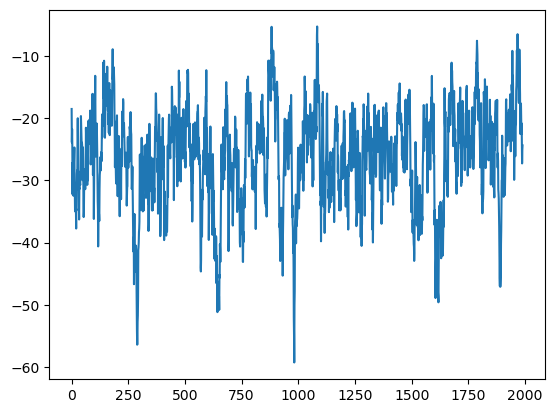

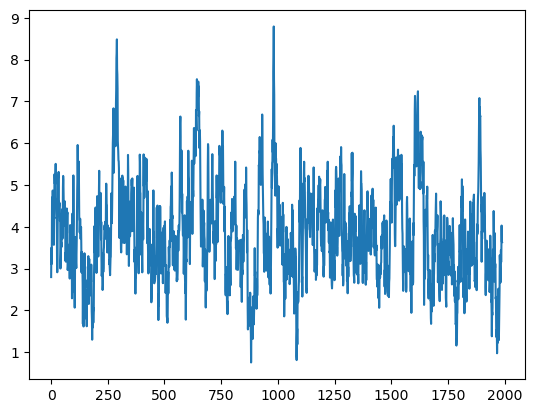

In [162]:
# inspect behavior of the run to check MCMC parameters
plt.plot(post_samples[:,0])
plt.show()

plt.plot(post_samples[:,1])
plt.show()

In [164]:
# compute posterior samples for x_*
x_stars = np.exp(-post_samples[:,0]/post_samples[:,1])

### Posterior Summary: 
The code below returns approximations to the:
1. **posterior mean** estimator for each entry of $\beta$
2. **95% credible intervals** for each entry of $\beta$

using the sampled regression coefficients.

In [166]:
betas_posterior_means = post_samples.mean(axis=0)
betas_credible_intervals = np.percentile(post_samples, [2.5, 97.5], axis=0)

print("The posterior mean for the intercept is: {}".format(np.round(betas_posterior_means[0],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals[:,0],1)))

print("")

print("The posterior mean for the slope is: {}".format(np.round(betas_posterior_means[1],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals[:,1],1)))

The posterior mean for the intercept is: -26.1
with 95 percent credible interval: [-43.1 -12.4]

The posterior mean for the slope is: 3.8
with 95 percent credible interval: [1.8 6.3]


The code below returns approximations to the:
1. **posterior mean** estimator for $x_*(\beta)$
2. **95% credible intervals** for $x_*(\beta)$

using the sampled regression coefficients.

In [168]:
x_stars_posterior_means = x_stars.mean(axis=0)
x_stars_credible_intervals = np.percentile(x_stars, [2.5, 97.5], axis=0)

print("The posterior mean for the 50 percent lethality dose is: {}".format(np.round(x_stars_posterior_means,1)))
print("with 95 percent credible interval: {}".format(np.round(x_stars_credible_intervals,1)))

The posterior mean for the 50 percent lethality dose is: 929.1
with 95 percent credible interval: [ 698.2 1304.1]


### Posterior Visualization:

First, let's look at the resulting posterior distribution on the regression coefficients $\beta$. This is approximated below using 2,000 samples drawn according to the code provided above.

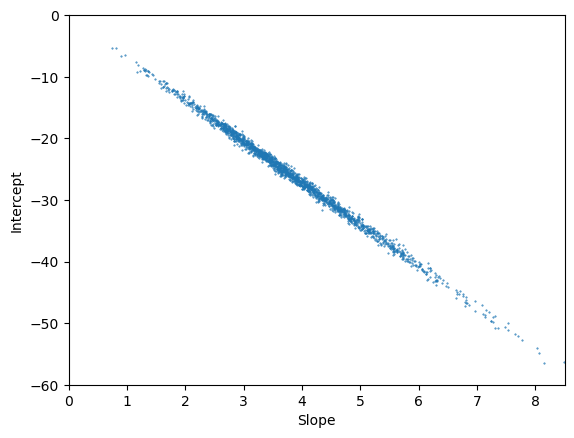

In [170]:
plt.scatter(post_samples[:,1],post_samples[:,0],s = 0.2)
plt.ylim([-60,0])
plt.xlim([0,8.5])
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.show()

Next, let's visualize the posterior for $\log(x_*(\beta))$, the log concentration at which the compound is expected to kill 50\% of subjects exposed to it. For consistency with the analysis in Racine, this posterior should put most of its mass between 6.5 and 7, with a peak near 6.75.

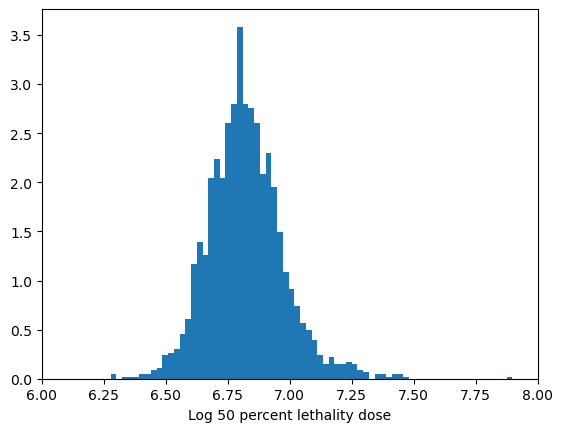

In [224]:
plt.hist(np.log(x_stars),70,density = True)
plt.xlim([6,8])
plt.xlabel("Log 50 percent lethality dose")
plt.show()

## Instructions for Experimentation:

For each prior specification below, rerun the sampling and posterior visualization code. Inspect the change in each posterior summary, then reason with the change in the posterior. Which regularization do you think is most reasonable as an inferential argument? How would you argue your choice to a regulator (think about which biases are conservative, and the differential impacts of under and overestimation of the 50 percent lethal dose)? Which set would you trust? What is the range of inferences you would be willing to return as the possible inferences that are plausible under a range of plausible prior choices? 

### Uniform
Start with a near to uniform prior. This can be achieved by setting $\sigma$ very large, $\mu$ very large, and $\nu$ very small. Try $\sigma = 400$, $\mu = 1000$ and $\nu = 1$. This is a very flat prior. You should notice that, since the data is "well separated", the likelihood alone places essentially no upper bound on the unknown parameters. This is a case where the MLE would be highly sensitive to changes in the data, and may be unbounded above.

In [265]:
# Set the prior parameters
sigma = 400 # default 0.1 (reasonably close to the expert provided prior)
mu = 1e3 # default 10 (weak regularization)
nu = 1 # defualt 40 (close to Gaussian tails)

# Intialize to the expert prior expectation
beta = np.array([-17.31,2.57])  

# Run MCMC sampling ... this may take a while
prior_param = np.array([sigma, mu, nu])
post_samples_new = metropolis_hastings(beta, toxicity_data, prior_param)

# compute posterior samples for x_*
x_stars_new = np.exp(-post_samples_new[:,0]/post_samples_new[:,1])

The posterior mean for the intercept is: -65.2
with 95 percent credible interval: [-150.9  -23.4]

The posterior mean for the slope is: 9.6
with 95 percent credible interval: [ 3.4 22.2]
The posterior mean for the 50 percent lethality dose is: 906.5
with 95 percent credible interval: [ 757.9 1123.9]


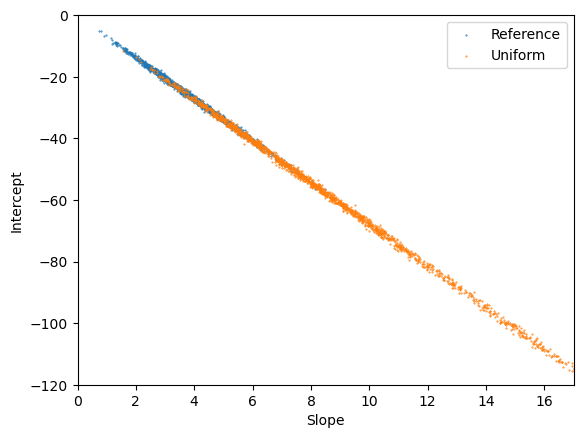

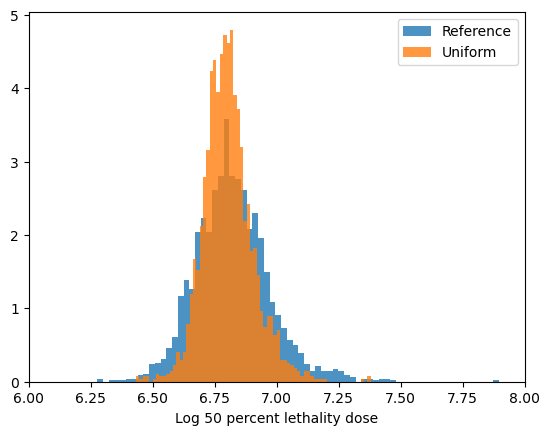

In [271]:
# print summaries
betas_posterior_means_new = post_samples_new.mean(axis=0)
betas_credible_intervals_new = np.percentile(post_samples_new, [2.5, 97.5], axis=0)

print("The posterior mean for the intercept is: {}".format(np.round(betas_posterior_means_new[0],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,0],1)))

print("")

print("The posterior mean for the slope is: {}".format(np.round(betas_posterior_means_new[1],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,1],1)))

x_stars_posterior_means_new = x_stars_new.mean(axis=0)
x_stars_credible_intervals_new = np.percentile(x_stars_new, [2.5, 97.5], axis=0)

print("The posterior mean for the 50 percent lethality dose is: {}".format(np.round(x_stars_posterior_means_new,1)))
print("with 95 percent credible interval: {}".format(np.round(x_stars_credible_intervals_new,1)))

# plot
plt.scatter(post_samples[:,1],post_samples[:,0],s = 0.2)
plt.scatter(post_samples_new[:,1],post_samples_new[:,0],s = 0.2)
plt.ylim([-120,0])
plt.xlim([0,17])
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.legend(['Reference','Uniform'])
plt.show()

plt.hist(np.log(x_stars),70,alpha = 0.8,density = True)
plt.hist(np.log(x_stars_new),70, alpha = 0.8,density = True)
plt.xlim([6,8])
plt.xlabel("Log 50 percent lethality dose")
plt.legend(['Reference','Uniform'])
plt.show()

### Expert

Now, adopt the expert prior. Set $\sigma = 0.1$, $\mu = 1000$, and $\nu = 40$. Does this succeed in constraining the unknown parameters? Pay attention to the axis scales when you read the plots below. We've zoomed in.

In [273]:
# Set the prior parameters
sigma = 0.1 # default 0.1 (reasonably close to the expert provided prior)
mu = 1e3 # default 10 (weak regularization)
nu = 40 # defualt 40 (close to Gaussian tails)

# Intialize to the expert prior expectation
beta = np.array([-17.31,2.57])  

# Run MCMC sampling ... this may take a while
prior_param = np.array([sigma, mu, nu])
post_samples_new = metropolis_hastings(beta, toxicity_data, prior_param)

# print summaries
betas_posterior_means_new = post_samples.mean(axis=0)
betas_credible_intervals_new = np.percentile(post_samples, [2.5, 97.5], axis=0)

# compute posterior samples for x_*
x_stars_new = np.exp(-post_samples_new[:,0]/post_samples_new[:,1])

The posterior mean for the intercept is: -47.0
with 95 percent credible interval: [-95.7 -20.2]

The posterior mean for the slope is: 6.9
with 95 percent credible interval: [ 2.9 14.1]
The posterior mean for the 50 percent lethality dose is: 891.2
with 95 percent credible interval: [ 736.8 1106.2]


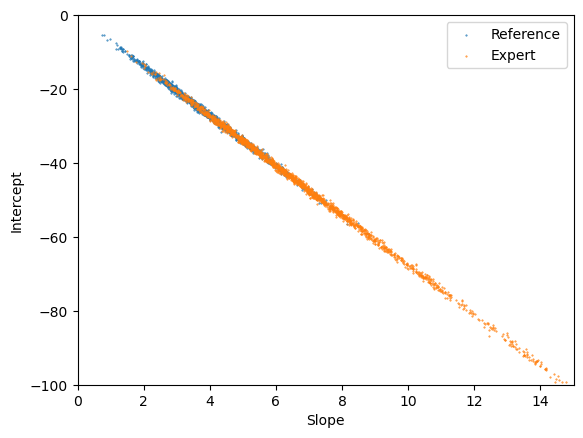

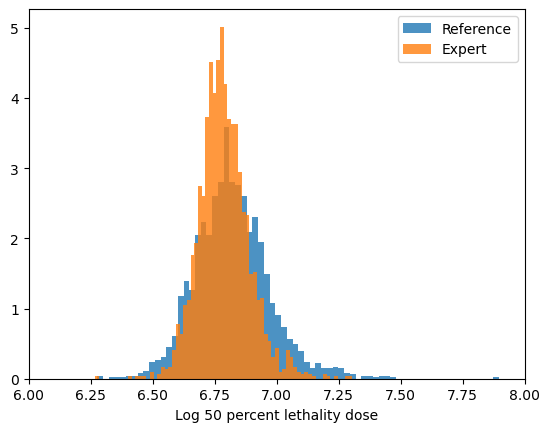

In [277]:
# print summaries
betas_posterior_means_new = post_samples_new.mean(axis=0)
betas_credible_intervals_new = np.percentile(post_samples_new, [2.5, 97.5], axis=0)

print("The posterior mean for the intercept is: {}".format(np.round(betas_posterior_means_new[0],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,0],1)))

print("")

print("The posterior mean for the slope is: {}".format(np.round(betas_posterior_means_new[1],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,1],1)))

x_stars_posterior_means_new = x_stars_new.mean(axis=0)
x_stars_credible_intervals_new = np.percentile(x_stars_new, [2.5, 97.5], axis=0)

print("The posterior mean for the 50 percent lethality dose is: {}".format(np.round(x_stars_posterior_means_new,1)))
print("with 95 percent credible interval: {}".format(np.round(x_stars_credible_intervals_new,1)))

# plot
plt.scatter(post_samples[:,1],post_samples[:,0],s = 0.2)
plt.scatter(post_samples_new[:,1],post_samples_new[:,0],s = 0.2)
plt.ylim([-100,0])
plt.xlim([0,15])
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.legend(['Reference','Expert'])
plt.show()

plt.hist(np.log(x_stars),70,alpha = 0.8,density = True)
plt.hist(np.log(x_stars_new),70, alpha = 0.8,density = True)
plt.xlim([6,8])
plt.xlabel("Log 50 percent lethality dose")
plt.legend(['Reference','Expert'])
plt.show()

### Regularized

Regularize by restricting the variance. Try setting $\mu = 5$, $\mu = 1$, and $\mu = 0.2$. Leave $\sigma = 0.1$ and $\nu = 40$.

In [279]:
# Set the prior parameters
sigma = 0.1 # default 0.1 (reasonably close to the expert provided prior)
mu = 5 # default 10 (weak regularization) << CHANGE ME
nu = 40 # defualt 40 (close to Gaussian tails)

# Intialize to the expert prior expectation
beta = np.array([-17.31,2.57])  

# Run MCMC sampling ... this may take a while
prior_param = np.array([sigma, mu, nu])
post_samples_new = metropolis_hastings(beta, toxicity_data, prior_param)

# compute posterior samples for x_*
x_stars_new = np.exp(-post_samples_new[:,0]/post_samples_new[:,1])

The posterior mean for the intercept is: -20.6
with 95 percent credible interval: [-29.3 -11.6]

The posterior mean for the slope is: 3.0
with 95 percent credible interval: [1.7 4.3]
The posterior mean for the 50 percent lethality dose is: 940.0
with 95 percent credible interval: [ 652.5 1323.5]


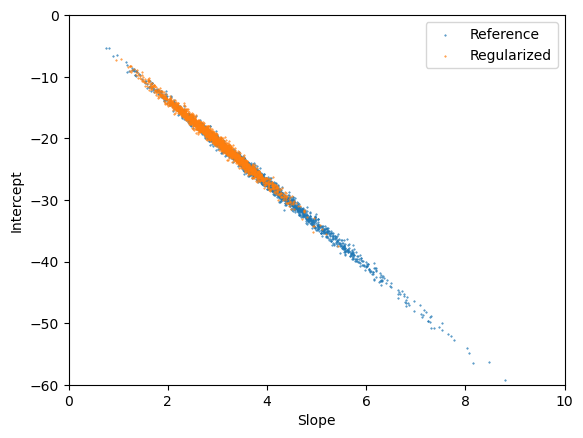

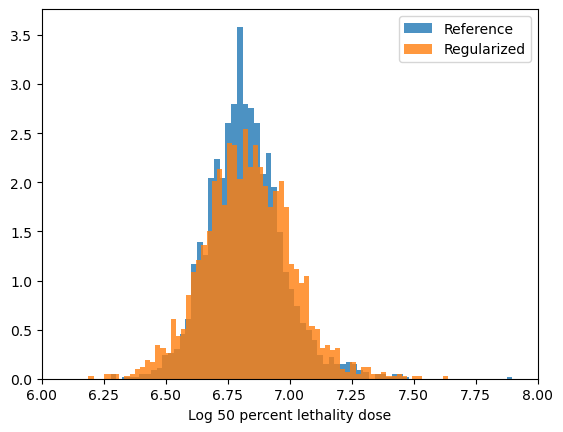

In [285]:
# print summaries
betas_posterior_means_new = post_samples_new.mean(axis=0)
betas_credible_intervals_new = np.percentile(post_samples_new, [2.5, 97.5], axis=0)

print("The posterior mean for the intercept is: {}".format(np.round(betas_posterior_means_new[0],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,0],1)))

print("")

print("The posterior mean for the slope is: {}".format(np.round(betas_posterior_means_new[1],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,1],1)))

x_stars_posterior_means_new = x_stars_new.mean(axis=0)
x_stars_credible_intervals_new = np.percentile(x_stars_new, [2.5, 97.5], axis=0)

print("The posterior mean for the 50 percent lethality dose is: {}".format(np.round(x_stars_posterior_means_new,1)))
print("with 95 percent credible interval: {}".format(np.round(x_stars_credible_intervals_new,1)))

# plot
plt.scatter(post_samples[:,1],post_samples[:,0],s = 0.2)
plt.scatter(post_samples_new[:,1],post_samples_new[:,0],s = 0.2)
plt.ylim([-60,0])
plt.xlim([0,10])
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.legend(['Reference','Regularized'])
plt.show()

plt.hist(np.log(x_stars),70,alpha = 0.8,density = True)
plt.hist(np.log(x_stars_new),70, alpha = 0.8,density = True)
plt.xlim([6,8])
plt.xlabel("Log 50 percent lethality dose")
plt.legend(['Reference','Regularized'])
plt.show()

### Robust

Set $\sigma = 0.1$ and $\mu = 5$. Relax the tails of the prior by setting $\nu = 4$, then $\nu = 2$, then $\nu = 1$. Pay attention to the outlying samples.

In [287]:
# Set the prior parameters
sigma = 0.1 # default 0.1 (reasonably close to the expert provided prior)
mu = 5 # default 10 (weak regularization) 
nu = 2 # defualt 40 (close to Gaussian tails) << CHANGE ME

# Intialize to the expert prior expectation
beta = np.array([-17.31,2.57])  

# Run MCMC sampling ... this may take a while
prior_param = np.array([sigma, mu, nu])
post_samples_new = metropolis_hastings(beta, toxicity_data, prior_param)

# compute posterior samples for x_*
x_stars_new = np.exp(-post_samples_new[:,0]/post_samples_new[:,1])

The posterior mean for the intercept is: -26.1
with 95 percent credible interval: [-43.1 -12.4]

The posterior mean for the slope is: 3.8
with 95 percent credible interval: [1.8 6.3]
The posterior mean for the 50 percent lethality dose is: 929.1
with 95 percent credible interval: [ 698.2 1304.1]


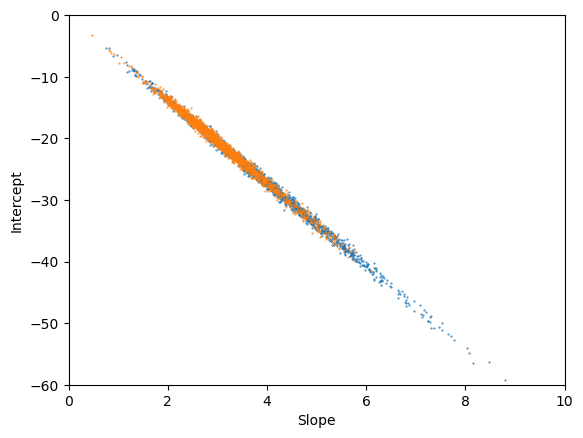

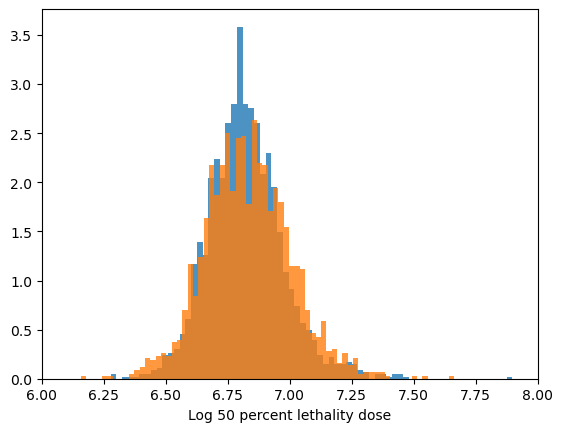

In [288]:
# print summaries
betas_posterior_means_new = post_samples.mean(axis=0)
betas_credible_intervals_new = np.percentile(post_samples, [2.5, 97.5], axis=0)

print("The posterior mean for the intercept is: {}".format(np.round(betas_posterior_means_new[0],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,0],1)))

print("")

print("The posterior mean for the slope is: {}".format(np.round(betas_posterior_means_new[1],1)))
print("with 95 percent credible interval: {}".format(np.round(betas_credible_intervals_new[:,1],1)))

x_stars_posterior_means_new = x_stars.mean(axis=0)
x_stars_credible_intervals_new = np.percentile(x_stars, [2.5, 97.5], axis=0)

print("The posterior mean for the 50 percent lethality dose is: {}".format(np.round(x_stars_posterior_means_new,1)))
print("with 95 percent credible interval: {}".format(np.round(x_stars_credible_intervals_new,1)))

# plot
plt.scatter(post_samples[:,1],post_samples[:,0],s = 0.2)
plt.scatter(post_samples_new[:,1],post_samples_new[:,0],s = 0.2)
plt.ylim([-60,0])
plt.xlim([0,10])
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.show()

plt.hist(np.log(x_stars),70,alpha = 0.8,density = True)
plt.hist(np.log(x_stars_new),70, alpha = 0.8,density = True)
plt.xlim([6,8])
plt.xlabel("Log 50 percent lethality dose")
plt.show()

### Discussion

Based on your observations, make an argument to yourself about what prior (or set of priors) you would pick if trying to infer the 50 percent lethal dose for use in writing regulation. Think about:

- How to motivate your choice of prior
- Whether you can anticipate the types of errors it would induce if (as is certain) it is misspecified
- The degree to which it balances induced bias for reduced variance (in posterior and in sampling over new data sets)
- Whether you could justify the errors induced as misspecification as errors in the "right" direction (towards overestimation for safety, towards underestimation for experimentation and research)
- How you would explain to an audience your range of plausible conclusions, and how you would disambiguate within model uncertainty (posterior variance), from modeling uncertainty.